# Week 8: The Heat Equation and the Crank-Nicholson Method

## Library Imports Go Here

In [750]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import eye
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

from matplotlib.animation import FuncAnimation
from IPython.display import HTML


## The Numerical Algorithms for the Heat Equation

<font color = blue>
We want code that will solve (find $\tau(s)$) for the generic heat equation
    $$
    \lambda(s)\tau''(s) + \lambda'(s)\tau'(s) = -h(s)
    $$
where the functions $\lambda(s)$ and $h(s)$ are given, and the boundary conditions for $\tau(s)$ are:
    $$
    \tau(0) = 0 \, , \hspace{.5in} \tau(1) = 1
    $$
In order to do this, we convert the equation into a matrix problem of the form
    $$
    \mathbb{M}\vec{\tau} = -(\vec{h} + \vec{b})
    $$

(where the matrix $\mathbb{M}$ encodes the differential operator on the right-hand-side, the vector $\vec{h}$ encodes the source function, and the vector $\vec{b}$ encodes the boundary conditions).

### Generating the Matrix

<font color = blue>
    
Create a function that will build the matrix $\mathbb{M}$.  Your matrix should take as inputs the size of the matrix (that is, of the spatial grid), and the function $\lambda(s)$, and should use produce a sparse array.  You should be able to start with the function you created in the previous part of the assignment and create a function which uses it.  Use a symmetric numerical derivative to find the function $\lambda'(s)$ with an $\epsilon$ parameter set to be 1/100 of the grid spacing.

In [755]:
def matrix(A, B, C, matrix_size, x_inf):
    """
    Function that efficiently generates our matrix M using sparse matrix techniques

    A : function A(x)
    B : function B(x)
    C : function C(x)
    matrix_size : the size of the matrix M
    x_inf : numerical infinity

    returns : matrix M as an array
    """
    rows = np.array([i + 1 for i in range(matrix_size - 2) for j in range(3)])
    rows = np.append([0, 0], rows)
    rows = np.append(rows, [matrix_size - 1, matrix_size - 1])

    n = matrix_size * 3 - 6  # Length of the array you want
    cols = np.repeat(np.arange(n//3 + 2), 3)[:n] + np.tile([0,1,2], n//3 + 1)[:n]
    cols = np.append([0, 1], cols)
    cols = np.append(cols, [matrix_size - 2, matrix_size - 1])

    del_x = x_inf/(matrix_size + 1)
    x_j = 0
    
    data = np.zeros(len(cols))
    k = 0
    for i in range(matrix_size):
        if i == 0:
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
            data[k] = (A(x_j)/del_x**2) + (B(x_j)/(2 * del_x))
            k += 1
        elif i == matrix_size - 1:
            data[k] = (A(x_j)/del_x**2) - (B(x_j)/(2 * del_x))
            k += 1
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
        else:
            data[k] = (A(x_j)/del_x**2) - (B(x_j)/(2 * del_x))
            k += 1
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
            data[k] = (A(x_j)/del_x**2) + (B(x_j)/(2 * del_x))
            k += 1
        x_j += del_x
    return sparse.coo_matrix((data, (rows, cols)), shape=(matrix_size, matrix_size))
    
def specific_matrix(matrix_size, lambda_s):
    """
    generates our sparce matrix M for the heat equation

    matrix_size : the size of the matrix (matrix_size x matrix_size)
    lambda_s : function lambda(s)

    returns : sparse matrix based on specific paramters
    """
    del_s = 1/(matrix_size + 1)
    def lambda_s_prime(s, e = del_s/100):
        return (lambda_s(s + e) - lambda_s(s - e)) / (2 * e)
    def C(x):
        return 0
    final_matrix = matrix(lambda_s, lambda_s_prime, C, matrix_size, 1)
    return final_matrix

def lambda_s(s):
    return 1

### Generating the Source Vector

<font color = blue>
    
Create a function that will build the vector $\vec{h}$.  It should take as inputs the size of the vector and the source function $h(s)$.  (Note that this is not typically sparse, so there's no point in using that technology).

In [758]:
def build_h(size, h):
    """
    Function to construct the h vector

    size : the saze of the vector we are making
    h : the source function h(s)

    returns : h vector
    """
    h_vec = np.zeros(size)
    del_s = 1 / (size + 1)
    for i in range(size):
        h_vec[i] = h(i * del_s)
    return h_vec

### Generating the Boundary Vector

<font color = blue>
Create a function that generates the vector $\vec{b}$ in which you will encode your boundary conditions.  It should take as inputs the size of the vector and the source function $\lambda(s)$, and use the same mechanism as before to calculate the numerical derivative $\lambda'(s)$.  

```
```

We could work hard at this and generate this in sparse form, but it turns out not to be super-important.  The "sparse" structure is designed to make sure we don't use up memory space in the computer storing a bunch of zeroes: instead we only store those elements of the matrix or vector which are non-zero.  But in this problem the matrix you have just created will have of order $N$ non-zero elements.  If we now store all $N$ elements of the vector $\vec{b}$, even those which aren't zero, we haven't changed the scaling of the number of values we are storing (it is still just of order $N$).

In [761]:
def generate_b(size, lambda_s):
    """
    Generates the boundary condition vector

    size : the size of the vector (and all of the other vectors)
    lambda_s : the source function lambda s
    """
    b = np.zeros(size)
    del_s = 1/(size + 1)
    def lambda_s_prime(s, e = del_s/100):
        return (lambda_s(s + e) - lambda_s(s - e)) / (2 * e)
    b[0] = 0
    b[size - 1] = ((lambda_s(del_s * size)) / ((del_s)**2)) + (lambda_s_prime(del_s * size) / (2 * del_s))
    return b

### The Solution Maker

<font color = blue>
We now want to use these pieces to create solutions to our differential equation

#### Solution Function

<font color = blue>
    Write a function that will take as inputs the size of the grid $N$, the source function $h(s)$ and conductivity $\lambda(s)$, and will output the solution to the differential equation in the form of two lists $[s_i]$ and $[\tau_i]$.  Your function should use the function scipy.sparse.linalg.inv to invert the matrix.

In [766]:
def solve_diff_eq(size, h, lambda_s):
    """
    solves M(tau) = -(h_vec + b_vec)

    size : the size of the spatial grid
    h : source function h(s)
    lambda_s : source function for conoductivity

    returns : n pairs of s and tau values
    """
    M = specific_matrix(size, lambda_s)
    b = generate_b(size, lambda_s)
    h = build_h(size, h)
    sumhb = -(h + b)
    M_inv = linalg.inv(M).toarray()
    tau_vals = np.matmul(M_inv, sumhb)
    s_vals = np.linspace(0, 1, size)
    return s_vals, tau_vals

#### A Simple Test

<font color = blue>
Test your function with the case $\lambda(s) = 1$ and $h(s) = 0$, using $N = 1000$.  Confirm that the solution matches the expected analytic solution $\tau(s) = s$.

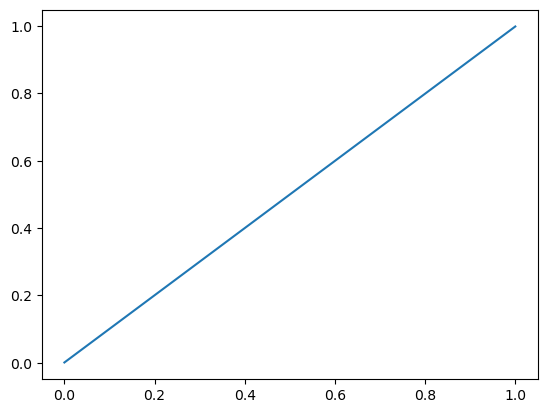

In [815]:
def lambda_s(s):
    return 1

def h(s):
    return 0

s, t = (solve_diff_eq(1000, h, lambda_s))
plt.plot(s, t)

## * Exploring the Heat Equation

<font color = blue>
    Now that we have the basic elements to produce solutions to the heat equation in 1D, we want to experiment with them.

### Linearly Varying Conductivity

<font color = blue>
    
Consider the case where the conductivity of the rod varies linearly along it, in the form
    $$
    \lambda(s) = 1 + \beta s
    $$
    
but there is still no source term.

Text(0.5, 1.0, 'Linearly Varying Conductivity')

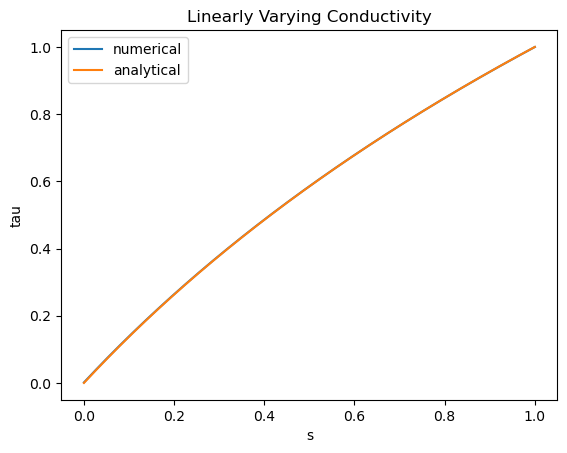

In [817]:
def lambda_s(s, B = 1):
    return 1 + (B * s)

s, t = solve_diff_eq(1000, h, lambda_s)
plt.plot(s, t, label = "numerical")

def analytic_solution(s, B = 1):
    return np.log(1 + (B * s)) / np.log(1 + B)

solns = analytic_solution(s)
plt.plot(s, solns, label = "analytical")
plt.legend()
plt.xlabel("s")
plt.ylabel("tau")
plt.title("Linearly Varying Conductivity")

#### Comparing with the Analytic Solution

<font color = blue>
In this case, it is also possible to find the solution analytically, and it is given by

$$
\tau(s) = \frac{\ln(1 + \beta s)}{\ln(1 + \beta)}
$$
    
Use your algorithm to find a solution for $\beta = 1$, and graph it together with the analytic solution.  **Discuss** the results.

#### Varying $\beta$

<font color = blue>
    
Now create a graph which shows the solutions for $\beta = -0.99, -0.9, 0, 10, 100$.   **Discuss** the results.

In [779]:
def lambda_s(s, B = -.99):
    return 1 + (B * s)

s, t_99 = (solve_diff_eq(1000, h, lambda_s))

def lambda_s(s, B = -.9):
    return 1 + (B * s)

s, t_9 = (solve_diff_eq(1000, h, lambda_s))

def lambda_s(s, B = 0):
    return 1 + (B * s)

s, t_0 = (solve_diff_eq(1000, h, lambda_s))

def lambda_s(s, B = 10):
    return 1 + (B * s)

s, t_10 = (solve_diff_eq(1000, h, lambda_s))

def lambda_s(s, B = 100):
    return 1 + (B * s)

s, t_100 = (solve_diff_eq(1000, h, lambda_s))

def analytic_solution(s, B = -.99):
    return np.log(1 + (B * s)) / np.log(1 + B)

solns_99 = analytic_solution(s)

def analytic_solution(s, B = -.9):
    return np.log(1 + (B * s)) / np.log(1 + B)

solns_9 = analytic_solution(s)

solns_0 = np.zeros(len(s)) ## dividing by zero so all vals are zero/DNE

def analytic_solution(s, B = 10):
    return np.log(1 + (B * s)) / np.log(1 + B)

solns_10 = analytic_solution(s)

def analytic_solution(s, B = 100):
    return np.log(1 + (B * s)) / np.log(1 + B)

solns_100 = analytic_solution(s)

<function matplotlib.pyplot.show(close=None, block=None)>

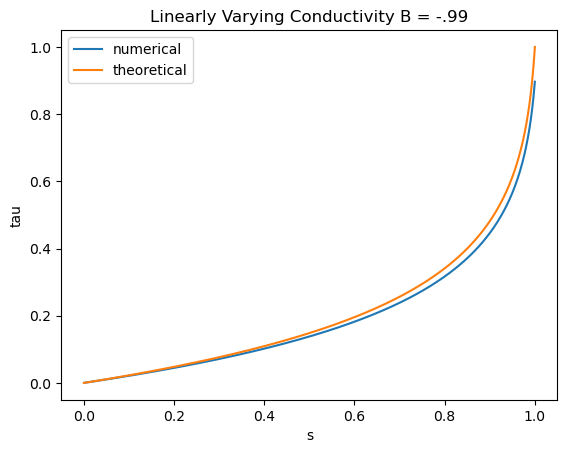

In [819]:
plt.plot(s, t_99, label = "numerical")
plt.plot(s, solns_99, label = "theoretical")
plt.xlabel("s")
plt.ylabel("tau")
plt.title("Linearly Varying Conductivity B = -.99")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

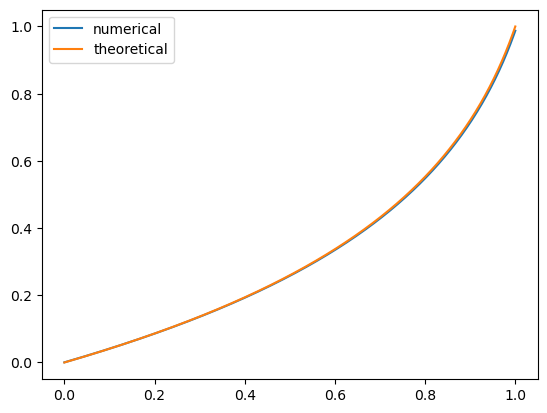

In [781]:
plt.plot(s, t_9, label = "numerical")
plt.plot(s, solns_9, label = "theoretical")
plt.xlabel("s")
plt.ylabel("tau")
plt.title("Linearly Varying Conductivity B = -.09")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

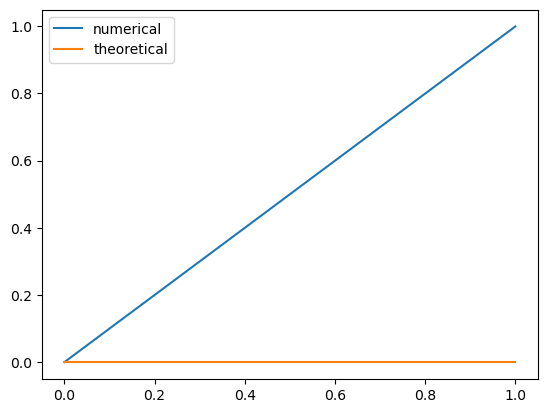

In [782]:
plt.plot(s, t_0, label = "numerical")
plt.plot(s, solns_0, label = "theoretical")
plt.xlabel("s")
plt.ylabel("tau")
plt.title("Linearly Varying Conductivity B = 0")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

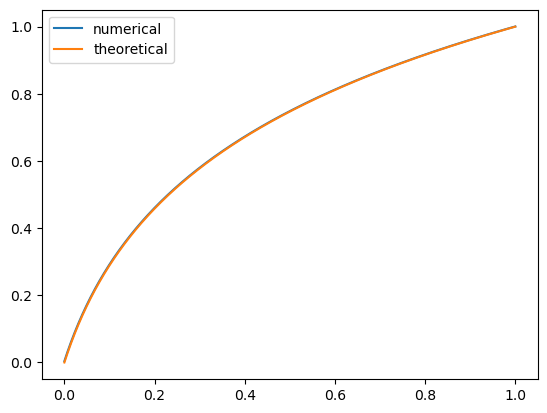

In [783]:
plt.plot(s, t_10, label = "numerical")
plt.plot(s, solns_10, label = "theoretical")
plt.xlabel("s")
plt.ylabel("tau")
plt.title("Linearly Varying Conductivity B = 10")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

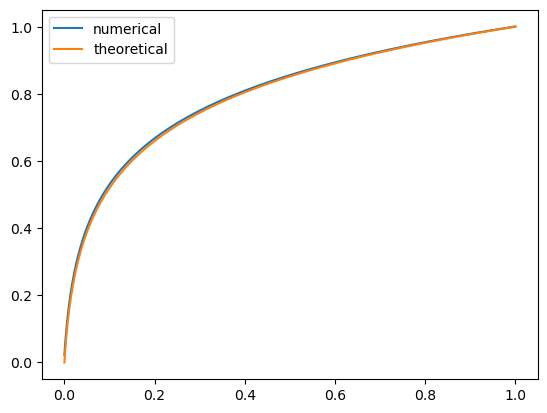

In [784]:
plt.plot(s, t_100, label = "numerical")
plt.plot(s, solns_100, label = "theoretical")
plt.xlabel("s")
plt.ylabel("tau")
plt.title("Linearly Varying Conductivity B = 100")
plt.show

In these graphs of linearly varying conductivity with varying B, we can see that when B is higher the rod is disproportionaly hot at the beginning of the rod, whereas when B gets smaller, the opposite is true. We can also see the the when B = 0 the rod is the same temperature throughout. 

### Sinusoidally Varying Conductivity

<font color = blue>
    
Now let's consider the case where the conductivity varies sinusoidally across the rod (so parts of the rod which have high conductivity are interspersed with parts of the rod which have low conductivity).  Let's say
    $$
    \lambda(s) = 1 + A\sin(k s)
    $$
where $A = 0.99$ and $k = 20$.  Create plots of both the conductivity itself and the temperature across the rod.   **Discuss** the results.

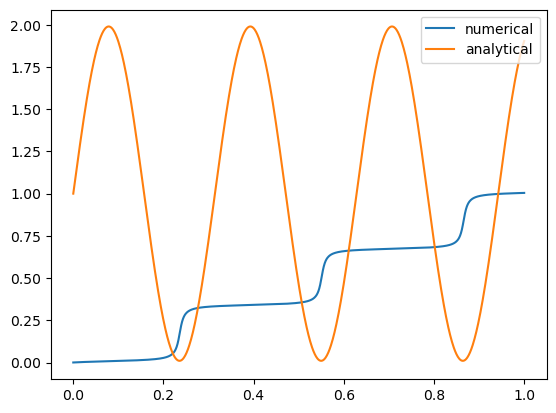

In [787]:
def lambda_s(s, A = .99, k = 20):
    return 1 + (A * np.sin(k * s))

s, t = (solve_diff_eq(1000, h, lambda_s))
t_soln = lambda_s(s)

plt.plot(s, t, label = "numerical Temp")
plt.plot(s, t_soln, label = "conductivity")
plt.xlabel("s")
plt.ylabel("tau")
plt.title("Conductivity and temperature")
plt.legend()

In this graph we can see that as the conductivity oscillates, the temperature of the rod increases. Notice that the periodic increase in temperature occurs very close to troughs of the conductivity function.

### Source Terms

<font color = blue>
    Now consider a rod with constant conductivity $\lambda(s) = 1$, but with a non-trivial source term in the form
    $$
    h(s) = \frac{h_0}{\sigma\sqrt{\pi}}e^{-(s - s_0)^2/\sigma^2}
    $$
    
This Gaussian function is appropriate for modeling sources that are nearly point-like, with $s_0$ giving the location of the source, $h_0$ giving its strength, and $\sigma$ giving the width it is spread out over.  (Choosing $\sigma$ small makes it closer to a point-like source).

#### The Significance of $h_0$

<font color = blue>
Create a single graph that shows solutions with $\sigma = 0.01$ and $s_0 = 0.5$, but with $h_0$ in the set

$$
h_0 \in \{-10, 1, 0, 1, 10\}
$$

 **Discuss** the results.

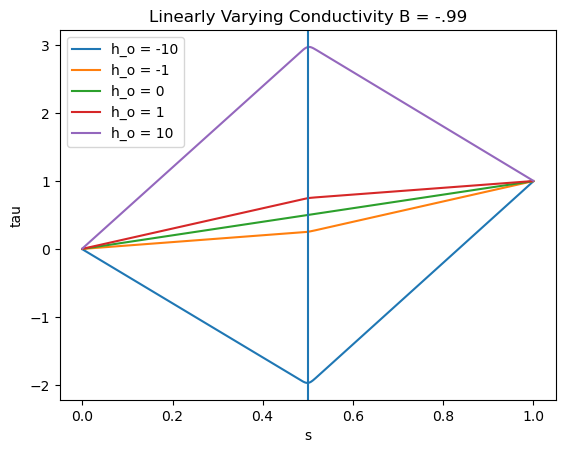

In [822]:
def lambda_s(s):
    return 1

h_o_vals = np.array([-10, -1, 0, 1, 10])

for i in range(len(h_o_vals)):
    def h(s, sigma = .01, s_o = .5, h_o = h_o_vals[i]):
        return (h_o / (sigma * np.sqrt(np.pi))) * np.exp(-(s - s_o)**2 / sigma**2)

    s, t = (solve_diff_eq(1000, h, lambda_s))
    plt.plot(s, t, label = f"h_o = {h_o_vals[i]}")

plt.xlabel("s")
plt.ylabel("tau")
plt.title("Significance of the strength of heat source (h_o)")
plt.legend()
plt.axvline(.5)

In this figure, there are a handful of interesting results. Firstly, we can see that in the middle of the rod, each of the respective initial strengths of the heat source show a dropoff (or increase for negative tau) in temperature. Another interesting thing is that we can see that both negative and positive initial strength have a proportional effect on the distribution of temperature.

#### The Significance of $s_0$

<font color = blue>
    Now create a graph that shows solutions where $h_0 = 10$ and $\sigma = 0.01$, but
    
$$
s_0 \in \{0.25, .5, 0.75\}
$$

 **Discuss** the results.

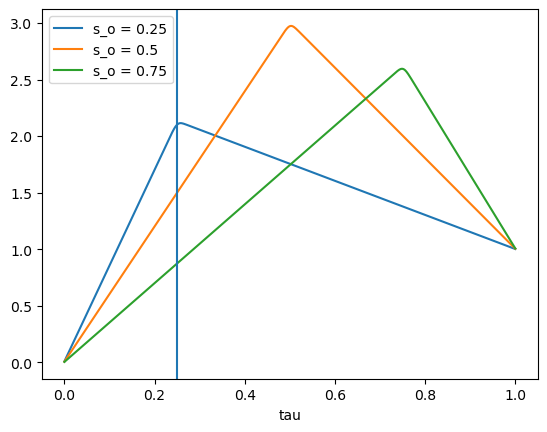

In [824]:
def lambda_s(s):
    return 1

s_o_vals = np.array([.25, .5, .75])

for i in range(len(s_o_vals)):
    def h(s, sigma = .01, s_o = s_o_vals[i], h_o = 10):
        return (h_o / (sigma * np.sqrt(np.pi))) * np.exp(-(s - s_o)**2 / sigma**2)

    s, t = (solve_diff_eq(1000, h, lambda_s))
    plt.plot(s, t, label = f"s_o = {s_o_vals[i]}")

plt.xlabel("s")
plt.ylabel("tau")
plt.legend()


In this figure, we can see a couple of interesting effects that the distance of the source has on the distribution of temperature. Firstly, the dropoff in temperature happens at the value of s_o.

#### The Significance of $\sigma$

<font color = blue>
    Finally, create a graph that shows solutions with $h_0 = 10$ and $s_0 = 0.5$, but with
    
$$
\sigma =\in \{0.5, 0.1, 0.05, 0.01, 0.005\}
$$

 **Discuss** the results.

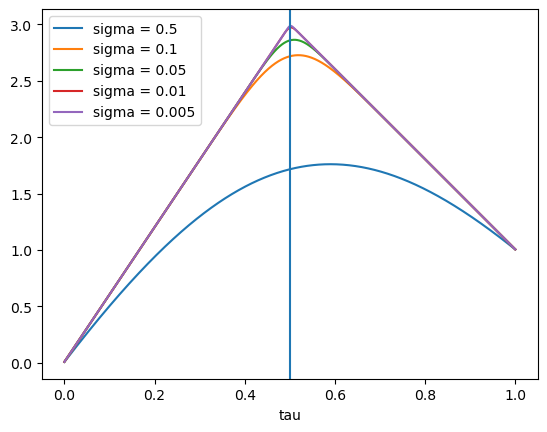

In [809]:
def lambda_s(s):
    return 1

sigma_vals = np.array([.5, .1, .05, .01, .005])

for i in range(len(sigma_vals)):
    def h(s, sigma = sigma_vals[i], s_o = .5, h_o = 10):
        return (h_o / (sigma * np.sqrt(np.pi))) * np.exp(-(s - s_o)**2 / sigma**2)

    s, t = (solve_diff_eq(1000, h, lambda_s))
    plt.plot(s, t, label = f"sigma = {sigma_vals[i]}")

plt.xlabel("s")
plt.xlabel("tau")
plt.legend()
plt.axvline(.5)


In this figure, the main result that we can see is that as the heat source becomes more like a point source, the temperature distribution gets closer and closer to linear. Oppositely, when the source is spread out, the temperature is more evenly spread across the rod.

## Basic Code for the Crank-Nicholson Method

### Generating Finite Diference Matrices

#### A Generic Sparse Matrix

<font color = blue>
Begin by copy-pasting your finite-difference code for generating a sparse coo-matrix $\mathbb{M}$ associated to an operator

$$
\hat{M} = A(x)\frac{\partial^2}{\partial x^2} + B(x)\frac{\partial}{\partial x} + C(x)
$$

given three functions $A(x)$, $B(x)$, and $C(x)$ into the space below.  You will then want to modify it slightly to account for the difference in the spatial grid we are now using as opposed to our old choice.

In [ ]:
def M(A, B, C, matrix_size, x_inf):
    """
    Function that efficiently generates our matrix M using sparse matrix techniques

    A : function A(x)
    B : function B(x)
    C : function C(x)
    matrix_size : the size of the matrix M
    x_inf : numerical infinity

    returns : matrix M as an array
    """
    rows = np.array([i + 1 for i in range(matrix_size - 2) for j in range(3)])
    rows = np.append([0, 0], rows)
    rows = np.append(rows, [matrix_size - 1, matrix_size - 1])

    n = matrix_size * 3 - 6  # Length of the array
    cols = np.repeat(np.arange(n//3 + 2), 3)[:n] + np.tile([0,1,2], n//3 + 1)[:n]
    cols = np.append([0, 1], cols)
    cols = np.append(cols, [matrix_size - 2, matrix_size - 1])

    del_x = (2 * x_inf) / (matrix_size + 1)
    x_j = -x_inf
    
    data = np.zeros(len(cols))
    k = 0
    for i in range(matrix_size):
        if i == 0:
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
            data[k] = (A(x_j)/del_x**2) + (B(x_j)/(2 * del_x))
            k += 1
        elif i == matrix_size - 1:
            data[k] = (A(x_j)/del_x**2) - (B(x_j)/(2 * del_x))
            k += 1
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
        else:
            data[k] = (A(x_j)/del_x**2) - (B(x_j)/(2 * del_x))
            k += 1
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
            data[k] = (A(x_j)/del_x**2) + (B(x_j)/(2 * del_x))
            k += 1
        x_j += del_x
    return sparse.coo_matrix((data, (rows, cols)), shape=(matrix_size, matrix_size))

#### The Hamiltonian Matrix

<font color = blue>
    
Next, use that code to write a function which takes as input the dimensioness potential $V(x)$, and the spatial grid parameters $x_{\infty}$ and `matrix_size` = $N$, and outputs the Hamiltonian coo-type matrix $\mathbb{H}$.

In [ ]:
def H(V, x_inf, matrix_size):
    """
    Function that creates a sparse hamiltonian matrix

    V : potential function
    x_inf : numerical infinity
    matrix_size : size of our matrix (N by N)

    returns : the hamiltonian matrix
    """
    def A(x):
        return -1/2
    def B(x):
        return 0
    def C(x):
        return V(x)
    return M(A, B, C, matrix_size, x_inf)

def V(x):
    return 0
H(V, 1, 4).toarray()

### Constructing the Time-Evolution Code

#### Creating the T-Matrix

<font color = blue>
    
Now, write a  function that takes as inputs the dimensionless potential $V(x)$, the spatial grid parameters $x_{\infty}$ and `matrix_size` = $N$, and the time grid parameters `final_time` = $T$ and `time_count` = $M$, and outputs the matrix $\mathbb{T}$ defined as

$$
\mathbb{T} = \left(\mathbb{I} - \frac{i\Delta_t}{2}\mathbb{H}\right)\left(\mathbb{I} + \frac{i\Delta_t}{2}\mathbb{H}\right)^{-1}
$$

Test your code using $V(x) = 0$, $x_{\infty} = 1$, $N = 4$, $T = 10$, and $M = 1000$, and confirm that the matrix generated is unitary (meaning its conjugate transpose is also its inverse.)

In [ ]:
def T_matrix(V, x_inf, matrix_size, final_time, time_count):
    """
    function that generates our matrix T as defined above

    V : poential function
    x_inf : numerical infinity
    matrix_size : size of matrix N by N
    final_time : final time for our time gride
    time_count : number of items in our time grid

    returns : matrix T as defined above
    """
    Hamiltonian = H(V, x_inf, matrix_size)
    I = eye(matrix_size, format = "csr")
    del_t = final_time / time_count
    T1 = (I - (1j * del_t * Hamiltonian / 2))
    T2 = linalg.inv(I + (1j * del_t * Hamiltonian / 2))
    return T1.dot(T2)

def V(x):
    return 0

T = T_matrix(V, 1, 4, 10, 1000)
T_conjugate_transpose = np.transpose(T).conj()
T_inverse = linalg.inv(T)

print(T_conjugate_transpose)
print("\n")
print(T_inverse)

#### The Time Evolution Code


<font color = blue>
Now we will put the pieces together and generate the essential piece of code.  It should take as inputs the initial wavefunction $\Psi(x, 0) = \psi(x)$, the potential $V(x)$, the spatial grid parameters $x_{\infty}$ and $N$, and the time grid parameters $T$ and $M$.  It should output a "list of lists", structured as

$$
[\vec{\Psi}^{0}, \vec{\Psi}^{1}, \vec{\Psi}^{2}, \dots ] = [[\Psi^0_1, \Psi^0_2, \dots, \Psi^0_N], [\Psi^1_1, \Psi^1_2, \dots, \Psi^1_N], \dots, [\Psi^M_1, \Psi^M_2, \dots, \Psi^M_N]]
$$

Note that the first thing your code will need to do is convert the initial function $\psi(x)$ into the vector $\vec{\Psi}^{0}$.  As usual, you will then use a loop structure to iteratively generate the vectors $\vec{\Psi}^{n}$.  But be careful to create the matrix $\mathbb{T}$ before you enter the loop: this inolves inverting a matrix, which is a time-consuming operation, and since we don't have to do it again at each time step we certaintly do not want to.

In [ ]:
def time_evolution(psi_initial, V, x_inf, matrix_size, final_time, time_count):
    """
    function that generates the time evolution of psi

    psi_initial : psi function at t = 0
    V : poential function
    x_inf : numerical infinity
    matrix_size : size of matrix N by N
    final_time : final time for our time gride
    time_count : number of items in our time grid

    returns : list of lists with each item of the outer list corresponding to components
    of the wavefunction at time 0 - M and inner list components corresponding to components
    0 - N
    """
    del_x = (2 * x_inf) / (matrix_size + 1)
    x_j = -x_inf
    first_component = np.zeros(matrix_size, dtype=complex) # first component of Psi (first time val)
    for i in range(matrix_size):
        first_component[i] = psi_initial(-x_inf + (del_x * (i + 1)))
    Psi = np.zeros((time_count, matrix_size), dtype=complex)
    Psi[0] = first_component
    T = T_matrix(V, x_inf, matrix_size, final_time, time_count)
    for i in range(time_count - 1):
        Psi[i + 1] = T.dot(Psi[i])
    return Psi

#### Plotting Details

<font color = blue>
In order to make it easy to plot the results, write a quick function that takes as inputs the spatial grid parameters $N$ and $x_{\infty}$, and outputs a numpy array of positions.  

In [ ]:
def positions(matrix_size, x_inf):
    return np.linspace(-x_inf + ((2 * x_inf) / (matrix_size + 1)), -x_inf + (matrix_size * ((2 * x_inf) / (matrix_size + 1))), matrix_size)


## Time Evolution in Free Space

<font color = blue>
Now we want to use our code to analyze the evolution of a wavefunction in free space, where $V(x) = 0$.  We will use two different initial wavefunction shapes:

$$
\psi_A(x) = \frac{1}{\pi^{1/4}\sqrt{\sigma}} \, e^{ip_0x} \, e^{-\frac{(x - x_0)^2}{2\sigma^2}}
$$

and

$$
\psi_B(x) = \left\{\begin{array}{rcl} 0 & \mbox{for} & x < x_0 - \sigma \\ \\ \sqrt{\frac{3}{2\sigma^3}} \, (x - x_0 + \sigma) e^{ip_0x} & \mbox{for} & x_0 - \sigma \le x < x_0 \\ \\ -\sqrt{\frac{3}{2\sigma^3}} \, (x - x_0 - \sigma) e^{ip_0x} & \mbox{for} & x_0 \le x < x_0 + \sigma \\ \\ 0 & \mbox{for} & x_0 + \sigma \le x \end{array}\right.
$$

Both of these wavefunctions are correctly normalized, and are determined by three paramters $\{x_0, p_0, \sigma\}$: the first controls the initial value of $\langle x \rangle$, the second controls the initial value of $\langle p \rangle$, and the third controls the initial uncertainty in both position and momentum.

### Initial Functions

<font color = blue>
Define functions for each of the two initial wavefunction we are interested in.  Plot each, with the choices $x_0 = p_0 = 0$ and $\sigma = 1$.

In [ ]:
def psiA(x, x_o = 0, p_o = 0, sigma = 1):
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * (np.exp(1j * p_o * x)) * (np.exp(-(x - x_o)**2 / (2 * sigma**2)))

def psiB(x, x_o = 0, p_o = 0, sigma = 1):
    if x < x_o - sigma or x >= x_o + sigma:
        return 0
    elif x - sigma <= x and x < x_o:
        return np.sqrt(2 / 2 * sigma**3) * (x - x_o + sigma) * np.exp(1j * p_o * x)
    else:
        return -np.sqrt(2 / 2 * sigma**3) * (x - x_o - sigma) * np.exp(1j * p_o * x)

### Using Time Evolution

#### Visualizing as an Animation

<font color = blue>
    
Starting with the initial wavefunction $\psi_A(x)$ and the parameters $x_0 = p_0 = 0$ and $\sigma = 1$, generate the time evolution of this wavefunction, using grid parameters $x_{\infty} = 20$, $N = 1000$, $T = 5$, and $M = 100$.  Then, create an animation of the *magnitude* of the wavefunction (remember the wavefunction is generally complex, so this step is important).

For creating animations within the jupyter environment, I found the following helpful:

https://www.numfys.net/howto/animations/

https://matplotlib.org/stable/api/animation_api.html

http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/

In [ ]:
from matplotlib.animation import FuncAnimation

In [ ]:
psi_A = time_evolution(psiA, V, 20, 1000, 5, 100)

fig, ax = plt.subplots()
line, = ax.plot(positions(1000, 20), abs(psi_A[0]))
ax.set_xlabel("position")
ax.set_ylabel("|psi_A|")

def update(frame):
    line.set_data(positions(1000, 20), abs(psi_A[frame]))
    return line,

ani = FuncAnimation(fig, update, frames=range(100), interval=50, blit=False)

video = ani.to_jshtml()
display(HTML(video))

Its important to note here that when looking at the magnitude of the wavefunction I was unsure to use abs() or $\sqrt{psi_A[i]^2}$. I chose abs() because I believe there is some error with how the computer process $\sqrt{psi_A[i]^2}$.

#### Grid Parameters and Limitations

<font color = blue>
    
Repeat the above exericise, with the same initial wavefunction, but this time with grid parameters $x_{\infty} = 20$, $N = 1000$, $T = 10$, and $M = 100$.  **Discuss** briefly what occurs at the later times, and how grid parameter choices need to be made in order to obtain physically reasonable results.

In [ ]:
psi_A = time_evolution(psiA, V, 20, 1000, 10, 100)

fig, ax = plt.subplots()
line, = ax.plot(positions(1000, 20), abs(psi_A[0]))
ax.set_xlabel("position")
ax.set_ylabel("|psi_A|")

def update(frame):
    line.set_data(positions(1000, 20), abs(psi_A[frame]))
    return line,

ani = FuncAnimation(fig, update, frames=range(100), interval=50, blit=False)

video = ani.to_jshtml()
display(HTML(video))

As can be seen in the graphs, at later times, the wavefunction begins to show unusual oscillations at the positions farthest from x = 0. I think that this happens when we set T = 10 because the wavefunction reaches $\pm$ x_inf while its value is not close enough to zero. This being said, we can say that unrealistic things happen when our wavefunction is closer to the ends of the spatial grid, and when the value of $\psi_A$ is significant it becomes utterly apparent in the time evolution graph. Note that if we change the y limits in the first graph we can also see this happening, just at a much less significant scale.

#### * Exploring the Implications

<font color = blue>
    
Now run four additional examples: two using $\psi_A(x)$ and two using $\psi_B(x)$, for different choices of $\sigma$, $x_0$ and $p_0$.  Make sure you incorporate at least one positive value of $p_0$ and at least one negative value of $p_0$.  In each case, adjust your grid parameter choices to ensure physically reasonable results over a long enouh time frame that you can tell what is happening.  **Discuss** the results thoroughly.

In [ ]:
def psiA1(x, x_o = 1, p_o = 1, sigma = 2):
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * (np.exp(1j * p_o * x)) * (np.exp(-(x - x_o)**2 / (2 * sigma**2)))

def psiB1(x, x_o = 1, p_o = 1, sigma = 2):
    if x < x_o - sigma or x >= x_o + sigma:
        return 0
    elif x - sigma <= x and x < x_o:
        return np.sqrt(2 / 2 * sigma**3) * (x - x_o + sigma) * np.exp(1j * p_o * x)
    else:
        return -np.sqrt(2 / 2 * sigma**3) * (x - x_o - sigma) * np.exp(1j * p_o * x)

def psiA2(x, x_o = -1, p_o = -1, sigma = .5):
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * (np.exp(1j * p_o * x)) * (np.exp(-(x - x_o)**2 / (2 * sigma**2)))

def psiB2(x, x_o = -1, p_o = -1, sigma = .5):
    if x < x_o - sigma or x >= x_o + sigma:
        return 0
    elif x - sigma <= x and x < x_o:
        return np.sqrt(2 / 2 * sigma**3) * (x - x_o + sigma) * np.exp(1j * p_o * x)
    else:
        return -np.sqrt(2 / 2 * sigma**3) * (x - x_o - sigma) * np.exp(1j * p_o * x)

In [ ]:
psi_A = time_evolution(psiA1, V, 40, 1000, 10, 100)

fig, ax = plt.subplots()
line, = ax.plot(positions(1000, 20), abs(psi_A[0]))
ax.set_xlabel("position")
ax.set_ylabel("|psi_A|")

def update(frame):
    line.set_data(positions(1000, 20), abs(psi_A[frame]))
    return line,

ani = FuncAnimation(fig, update, frames=range(100), interval=50, blit=False)

video = ani.to_jshtml()
display(HTML(video))

In [ ]:
psi_A = time_evolution(psiA2, V, 40, 1000, 10, 100)

fig, ax = plt.subplots()
line, = ax.plot(positions(1000, 20), abs(psi_A[0]))
ax.set_xlabel("position")
ax.set_ylabel("|psi_A|")

def update(frame):
    line.set_data(positions(1000, 20), abs(psi_A[frame]))
    return line,

ani = FuncAnimation(fig, update, frames=range(100), interval=50, blit=False)

video = ani.to_jshtml()
display(HTML(video))

In [ ]:
psi_B = time_evolution(psiB1, V, 40, 1000, 10, 100)

fig, ax = plt.subplots()
line, = ax.plot(positions(1000, 20), abs(psi_B[0]))
ax.set_xlabel("position")
ax.set_ylabel("|psi_B|")

def update(frame):
    line.set_data(positions(1000, 20), abs(psi_B[frame]))
    return line,

ani = FuncAnimation(fig, update, frames=range(100), interval=50, blit=False)

video = ani.to_jshtml()
display(HTML(video))

In [ ]:
psi_B = time_evolution(psiB2, V, 80, 1000, 10, 100)

fig, ax = plt.subplots()
line, = ax.plot(positions(1000, 20), abs(psi_B[0]))
ax.set_xlabel("position")
ax.set_ylabel("|psi_B|")

def update(frame):
    line.set_data(positions(1000, 20), abs(psi_B[frame]))
    return line,

ani = FuncAnimation(fig, update, frames=range(100), interval=50, blit=False)

video = ani.to_jshtml()
display(HTML(video))

From these graphs we can see the rough effect that each constant x_o, p_o, and sigma have on the wavefunctions. Firstly, x_o as expected controls where the peak of the wavefunction is. Next, the momentum constant controls which direction the wavefunction moves as time goes by. When p_o is positive, the wavefunction moves in the positive x direction and vice versa. Along with this, the bigger p_o is the quicker the movement in the respective direction is. Lastly, sigma controls how spread out the wavefunction is. For example, with a bigger sigma, the wavefunction will be more spread out over a larger range of positions, and the peak will be lower. Another note is the spatial and time grids used for each of these results. In each case, I had to increase the spatial grids in order to prevent the numerical error that we observed before. Another note is that for the psi_b function, we see very large oscillations as a result of x_inf not being great enough.

## Time Evolution in the SHO Potential

<font color = blue>
Another classic potential to explore is the SHO potential, which we can non-dimensionalize to be

$$
V(x) = \frac{1}{2}x^2
$$

We want to repeat some of the analysis we just performed for "free space" using this potential.  This time, we will use just the initial Gaussian wavefunction,

$$
\psi_A(x) = \frac{1}{\pi^{1/4}\sqrt{\sigma}} \, e^{ip_0x} \, e^{-\frac{(x - x_0)^2}{2\sigma^2}}
$$

and we will focus on the three cases

$$
x_0 = 0, \ p_0 = 0, \ \sigma = 1
$$

$$
x_0 = 1, \ p_0 = 0, \ \sigma = 1
$$

$$
x_0 = 0, \ p_0 = 1, \ \sigma = 1
$$

In each of these cases you will find the grid parameter choices

$$
x_{\infty} = 10, \ N = 1000, \ T = 20, \ M = 200
$$

to be appropriate.

It will also be helpful for you to know that the first of these cases actually corresponds to an *energy eigenstate* of the quantum SHO system.  (How do states of definite energy evolve over time in quantum mechanics??)

Create animations for each of the three cases, and **discuss** what you see thoroughly.

* Note: you may run into issues with an error message claiming "IOPub data rate exceeded".  If so, you need to edit a config file that sets the allowed limits when you open a Jupyter notebook.

In [ ]:
# first case is psiA
def V(x):
    """
    potential function for SHO (non dimensionalized)     
    """
    return (1/2) * x**2 
    
def psiA3(x, x_o = 1, p_o = 0, sigma = 1):
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * (np.exp(1j * p_o * x)) * (np.exp(-(x - x_o)**2 / (2 * sigma**2)))

def psiA4(x, x_o = 0, p_o = 1, sigma = 1):
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * (np.exp(1j * p_o * x)) * (np.exp(-(x - x_o)**2 / (2 * sigma**2)))    

In [ ]:
psi_A = time_evolution(psiA, V, 10, 1000, 20, 200)

fig, ax = plt.subplots()
line, = ax.plot(positions(1000, 20), abs(psi_A[0]))
ax.set_xlabel("position")
ax.set_ylabel("|psi_A|")

def update(frame):
    line.set_data(positions(1000, 20), abs(psi_A[frame]))
    return line,

ani = FuncAnimation(fig, update, frames=range(100), interval=50, blit=False)

video = ani.to_jshtml()
display(HTML(video))

In this case, these results make sense because since the wavefunction is an energy eigenstate and the wavefunction has a state of definite energy the wavefunction will not have any time evolution. We can also notice that since there is no momentum and we are starting at equalibrium (in the SHO) the quantum SHO stays at rest.

In [ ]:
psi_A = time_evolution(psiA3, V, 10, 1000, 20, 200)

fig, ax = plt.subplots()
line, = ax.plot(positions(1000, 20), abs(psi_A[0]))
ax.set_xlabel("position")
ax.set_ylabel("|psi_A|")

def update(frame):
    line.set_data(positions(1000, 20), abs(psi_A[frame]))
    return line,

ani = FuncAnimation(fig, update, frames=range(100), interval=50, blit=False)

video = ani.to_jshtml()
display(HTML(video))

Here we can see the wavefunction oscillating. This happens because firstly, since the wavefunction is an energy eigenstate and the wavefunction has a state of definite energy the wavefunction does not spread out over time. Secondly, since the wavefunction starts at x = 1, the potential function causes the wavefunction to oscillate. We can relate this to the classical SHO because in this case, the at which location the particle is most likely to be observed oscillates like the SHO.

In [ ]:
psi_A = time_evolution(psiA4, V, 10, 1000, 20, 200)

fig, ax = plt.subplots()
line, = ax.plot(positions(1000, 20), abs(psi_A[0]))
ax.set_xlabel("position")
ax.set_ylabel("|psi_A|")

def update(frame):
    line.set_data(positions(1000, 20), abs(psi_A[frame]))
    return line,

ani = FuncAnimation(fig, update, frames=range(100), interval=50, blit=False)

video = ani.to_jshtml()
display(HTML(video))

here we can see that again, since the wavefunction is an energy eigenstate and the wavefunction has a state of definite energy the wavefunction does not spread out over time. Next, even though the wavefunction starts at "equilibrium", since there is momentum, the wavefunction oscillates between positive and negative x values. Again we can relate this to the classical SHO because in this case, the location the at which the particle is most likely to be observed oscillates like the SHO.

## Final Project Work

<font color = blue>
This week, you should submit your progress on your final project, in a separate Jupyter notebook.  Your notebook should be organized the same way these assignments are (broken into sections, code correctly commented, and short discussions after each section.)  Keep in mind that depending on the topic of your project, I may have very little experience with it, which means your discussions need to be that much better!

At the end, include a brief discussion of what you *intended* to accomplish as compared with what you *did* accomplish, as well as a plan of what you intend to do in the following week.